# Portfolio Optimization

A portfolio manager oversees multiple assets $(i=1,\dots,N)$ and a bank account $(i=N+1)$. For a specified number of stages $T$, the manager wants to maximize his utility by dynamically reblanacing the portfolio.
Let $\{r_{it}\}$ be   the return process of   asset $i$. At the end of each period, the position of $i^{th}$ asset $x_{it}$ equals the start position $x_{i,t-1}$, plus the realized return $r_{it} x_{i,t-1}$ during the period, plus the newly long positions $b_{it}$, minus the newly short positions $s_{it}$. Transaction costs are $f_b,f_s$ for buying and selling respectively. The capital in the bank account will be adjusted accordingly.

We consider a simple asset pricing model that decomposes the excess return as the return explained by Capital Asset Pricing Model (CAPM), alpha and idiosyncratic risk,
\begin{equation*}
    r_{it}  =  r_{ft} + \beta_i (r_{Mt}-r_{ft}) + \epsilon_{it}, \textrm{where}~ \epsilon_{it}\overset{i.i.d}{\sim} N(\alpha_i,\sigma_i),
\end{equation*}
where $\alpha_i,\beta_i,\sigma_i$ are assumed to be constant. We refer to $\{r_{ft} + \beta_i (r_{Mt}-r_{ft})\}$ as the market-exposure return process and $\{\epsilon_{it}\}$ as the idiosyncratic return process. The market return process $\{r_{Mt}\}$ is modelled as a first-order autoregressive process (AR) with normal generalized autoregressive conditional heteroscedastic GARCH(1,1) innovation due to,
\begin{align*}
    & r_{Mt} = \mu + \phi r_{M,t-1} + \epsilon_{Mt},\\
    & \epsilon_{Mt} = \sigma_{Mt} e_{Mt},\\
    & \sigma_{Mt}^2 = \omega + \alpha_1 \epsilon_{M,t-1}^2 + \alpha_2 \sigma_{M,t-1}^2,\\
    & e_{Mt}\overset{i.i.d}{\sim} N(0,1).
\end{align*}

Formulation
----------------

\begin{align*}
    \max~& U(r_T^\top x_T)\\
    \textrm{s.t.}~&\forall t=1,\dots,T,\forall i=1,\dots,N,\\
    & x_{it} = x_{i,capm,t} + x_{i,idio,t} + x_{i,t-1} + b_{it} - s_{it},\\
    & x_{N+1,t} = (1 + r_{ft}) x_{N+1,t-1} - (1+f_{b}) \sum_{i=1}^N b_{it} + (1-f_{s}) \sum_{i=1}^N s_{it},\\
    & x_{i,capm,t} = \big[r_{ft} + \beta_{i} (r_{Mt}-r_{ft})\big] x_{i,t-1}\\
    & x_{i,idio,t} = \epsilon_{it} x_{i,t-1},\\
    & \epsilon_{it}\overset{i.i.d}{\sim} N(\alpha_i,\sigma_i), \{r_{Mt}\} \sim \textrm{AR}(1)-\textrm{GARCH}(1,1),\\
    & x_{i0} = 0, x_{N+1,0} = \$ 100 \\
    & b_{it},s_{it},x_{it},x_{N+1,t}\geq 0.
\end{align*}

Deterministic solution
----------------

Formulation
-------------

For the deterministic case, we know the return $r_{i,t}* for all $i=1,\dots,N$ and $t=1,\dots,T$.

Therefore, the formulation is:

\begin{align*}
    \max~& \sum_{i=1}^{N+1} x_{iT} \\
    \textrm{s.t.}~&\forall t=1,\dots,T,\forall i=1,\dots,N,\\
    & x_{it} = r_{it} x_{i,t-1} + x_{i,t-1} + b_{it} - s_{it},\\
    & x_{N+1,t} = (1 + r_{ft}) x_{N+1,t-1} - (1+f_{b}) \sum_{i=1}^N b_{it} + (1-f_{s}) \sum_{i=1}^N s_{it},\\
    & x_{i0} = 0, x_{N+1,0} = \$ 100 \\
    & b_{it},s_{it},x_{it},x_{N+1,t}\geq 0.
\end{align*}

In [41]:
using CSV, DataFrames
using JuMP, Gurobi
using Plots
using Statistics

In [3]:
T = 10
N = 5 # The first N assets in prices

rf = 0.0005
fee = 0.001

prices = DataFrame(CSV.File("./data/prices.csv"))
prices = prices[:,2:end];

returns = similar(prices, 0)
for i in 1:size(prices)[2]-1
    m = collect(prices[i+1,:])./collect(prices[i,:])
    push!(returns, m)
end

In [4]:
m = Model(Gurobi.Optimizer)

@variable(m, 0 <= asset[1:N+1, 1:T])
@variable(m, 0 <= buy[1:N, 1:T]) 
@variable(m, 0 <= sell[1:N, 1:T])

for t in 1:T
    if t==1
        for i in 1:N
            @constraint(m, asset[i,1]==buy[i,1]-sell[i,1])
        end

        @constraint(m, asset[N+1,1]==100-
                        (1+fee)*sum(buy[i,1] for i in 1:N)+
                        (1-fee)*sum(sell[i,1] for i in 1:N))
    elseif t!=T
        for i in 1:N
            @constraint(m, asset[i,t]==returns[t,i]*asset[i,t-1]+buy[i,t]-sell[i,t])
        end
        @constraint(m, asset[N+1,t]==(1+rf)*asset[N+1,t-1]-
                        (1+fee)*sum(buy[i,t] for i in 1:N)+
                        (1-fee)*sum(sell[i,t] for i in 1:N))
    else
        for i in 1:N
            @constraint(m, asset[i,t]==returns[t,i]*asset[i,t-1])
        end
        @constraint(m, asset[N+1,t]==(1+rf)*asset[N+1,t-1])
    end
end

@objective(m, Max, sum(returns[T,i]*asset[i,T] for i in 1:N)+asset[N+1,T])

print(m)

Academic license - for non-commercial use only - expires 2022-01-02
Max 0.9951609172775089 asset[1,10] + 0.959016323176152 asset[2,10] + 0.9972865608852549 asset[3,10] + 1.0212551430851424 asset[4,10] + 0.9883144267720464 asset[5,10] + asset[6,10]


Subject to
 

asset[1,1] - buy[1,1] + sell[1,1] = 0.0
 asset[2,1] - buy[2,1] + sell[2,1] = 0.0
 asset[3,1] - buy[3,1] + sell[3,1] = 0.0
 asset[4,1] - buy[4,1] + sell[4,1] = 0.0
 asset[5,1] - buy[5,1] + sell[5,1] = 0.0
 asset[6,1] + 1.001 buy[1,1] + 1.001 buy[2,1] + 1.001 buy[3,1] + 1.001 buy[4,1] + 1.001 buy[5,1] - 0.999 sell[1,1] - 0.999 sell[2,1] - 0.999 sell[3,1] - 0.999 sell[4,1] - 0.999 sell[5,1] = 100.0
 -0.9804303432198941 asset[1,1] + asset[1,2] - buy[1,2] + sell[1,2] = 0.0
 -1.0001742143752306 asset[2,1] + asset[2,2] - buy[2,2] + sell[2,2] = 0.0
 -0.9916123561801408 asset[3,1] + asset[3,2] - buy[3,2] + sell[3,2] = 0.0
 -0.998046156166405 asset[4,1] + asset[4,2] - buy[4,2] + sell[4,2] = 0.0
 -0.9828974727095938 asset[5,1] + asset[5,2] - buy[5,2] + sell[5,2] = 0.0
 -1.0005 asset[6,1] + asset[6,2] + 1.001 buy[1,2] + 1.001 buy[2,2] + 1.001 buy[3,2] + 1.001 buy[4,2] + 1.001 buy[5,2] - 0.999 sell[1,2] - 0.999 sell[2,2] - 0.999 sell[3,2] - 0.999 sell[4,2] - 0.999 sell[5,2] = 0.0
 -0.95779546654909

In [5]:
optimize!(m)
@show termination_status(m)
@show primal_status(m)
@show dual_status(m)
@show objective_value(m)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60 rows, 160 columns and 294 nonzeros
Model fingerprint: 0xa2279ce2
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 15 rows and 39 columns
Presolve time: 0.00s
Presolved: 45 rows, 121 columns, 241 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0429621e+30   1.001000e+30   1.042962e+00      0s
      53    1.2084395e+02   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds
Optimal objective  1.208439488e+02

User-callback calls 93, time in user-callback 0.00 sec
termination_status(m) = MathOptInterface.OPTIMAL
primal_status(m) = MathOptInterface.FEASIBLE_POINT
dual_status(m) = MathOptInterface.FEASIBLE_POINT
objective_value(m) = 

120.84394876791842


120.84394876791842

In [6]:
value.(asset) 

6×10 Matrix{Float64}:
   0.0    0.0   100.0  100.529  …    0.0      0.0      0.0      0.0
   0.0    0.0     0.0    0.0       103.626  110.469    0.0      0.0
   0.0    0.0     0.0    0.0         0.0      0.0      0.0      0.0
   0.0    0.0     0.0    0.0         0.0      0.0    115.866  118.329
   0.0    0.0     0.0    0.0         0.0      0.0      0.0      0.0
 100.0  100.05    0.0    0.0    …    0.0      0.0      0.0      0.0

In [7]:
value.(buy) 

5×10 Matrix{Float64}:
 0.0  0.0  100.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0
 0.0  0.0    0.0  0.0    0.0    0.0  103.626  0.0    0.0    0.0
 0.0  0.0    0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0
 0.0  0.0    0.0  0.0  101.952  0.0    0.0    0.0  115.866  0.0
 0.0  0.0    0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0

In [8]:
value.(sell)

5×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  102.157    0.0    0.0  0.0    0.0    0.0
 0.0  0.0  0.0  0.0    0.0      0.0    0.0  0.0  116.098  0.0
 0.0  0.0  0.0  0.0    0.0      0.0    0.0  0.0    0.0    0.0
 0.0  0.0  0.0  0.0    0.0    103.781  0.0  0.0    0.0    0.0
 0.0  0.0  0.0  0.0    0.0      0.0    0.0  0.0    0.0    0.0

## Compare different scenarios

There are $100$ time points. We can use $100-T$ different starting points.

In [19]:
function portoflio_opt(;N=5, T=10, t_init=0, 
                        starting_value=100, fee=fee, rf=rf, returns=returns)
    m = Model(Gurobi.Optimizer)

    @variable(m, 0 <= asset[1:N+1, 1:T])
    @variable(m, 0 <= buy[1:N, 1:T]) 
    @variable(m, 0 <= sell[1:N, 1:T])

    for t in 1:T
        t_up = t_init+t
        if t==1
            for i in 1:N
                @constraint(m, asset[i,1]==buy[i,1]-sell[i,1])
            end

            @constraint(m, asset[N+1,1]==starting_value-
                            (1+fee)*sum(buy[i,1] for i in 1:N)+
                            (1-fee)*sum(sell[i,1] for i in 1:N))
        elseif t!=T
            for i in 1:N
                @constraint(m, asset[i,t]==returns[t_up,i]*asset[i,t-1]+
                                buy[i,t]-sell[i,t])
            end
            @constraint(m, asset[N+1,t]==(1+rf)*asset[N+1,t-1]-
                            (1+fee)*sum(buy[i,t] for i in 1:N)+
                            (1-fee)*sum(sell[i,t] for i in 1:N))
        else
            for i in 1:N
                @constraint(m, asset[i,t]==returns[t_up,i]*asset[i,t-1])
            end
            @constraint(m, asset[N+1,t]==(1+rf)*asset[N+1,t-1])
        end
    end

    @objective(m, Max, sum(returns[T+t_init,i]*asset[i,T] for i in 1:N)+asset[N+1,T])
    optimize!(m)

    return m
end

portoflio_opt (generic function with 8 methods)

In [20]:
models = []
wealths = []

for t_init=0:101-T
    model = portoflio_opt(N=5, T=10, t_init=t_init)
    #append!(models, model)
    append!(wealths, objective_value(model))
end

Academic license - for non-commercial use only - expires 2022-01-02
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60 rows, 160 columns and 294 nonzeros
Model fingerprint: 0xa2279ce2
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 15 rows and 39 columns
Presolve time: 0.00s
Presolved: 45 rows, 121 columns, 241 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0429621e+30   1.001000e+30   1.042962e+00      0s
      53    1.2084395e+02   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds
Optimal objective  1.208439488e+02

User-callback calls 93, time in user-callback 0.00 sec
Academic license - for non-commercial use only - expires 2022-01-02
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (

In [27]:
wealth_bank = 100*((1+rf)^T);

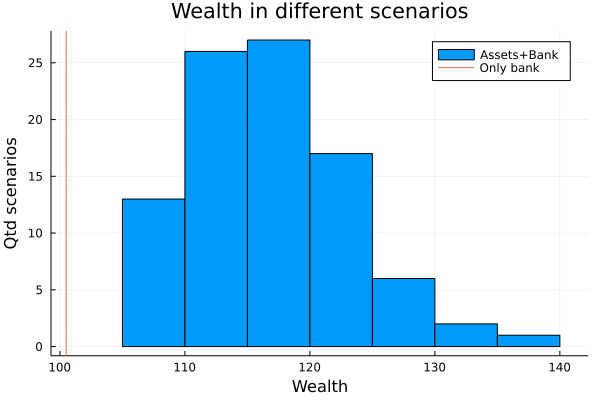

In [38]:
histogram(wealths, title = "Wealth in different scenarios", label="Assets+Bank")
vline!([wealth_bank], label="Only bank")
ylabel!("Qtd scenarios")
xlabel!("Wealth")

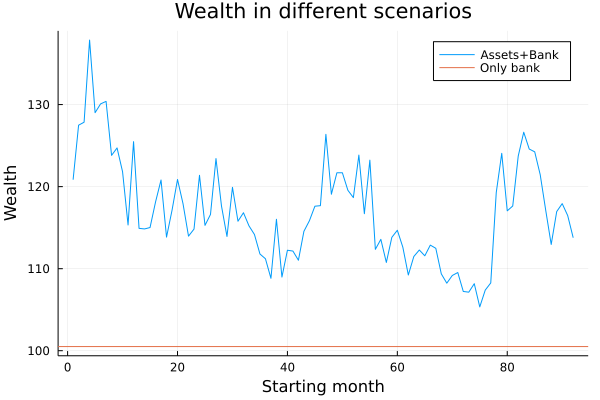

In [39]:
plot(wealths, title = "Wealth in different scenarios", label="Assets+Bank")
hline!([wealth_bank], label="Only bank")
xlabel!("Starting month")
ylabel!("Wealth")

## Different number of stages

In [43]:
mean_wealth = []
std_wealth = []

for T=1:100
    wealths = []
    for t_init=0:101-T
        model = portoflio_opt(N=5, T=T, t_init=t_init)
        append!(wealths, objective_value(model))
    end
    append!(mean_wealth, mean(wealths))
    append!(std_wealth, std(wealths))
end

Academic license - for non-commercial use only - expires 2022-01-02
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6 rows, 16 columns and 26 nonzeros
Model fingerprint: 0xb170618a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 6 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0042005e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.004200510e+02

User-callback calls 29, time in user-callback 0.00 sec
Academic license - for non-commercial use only - expires 2022-01-02
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 

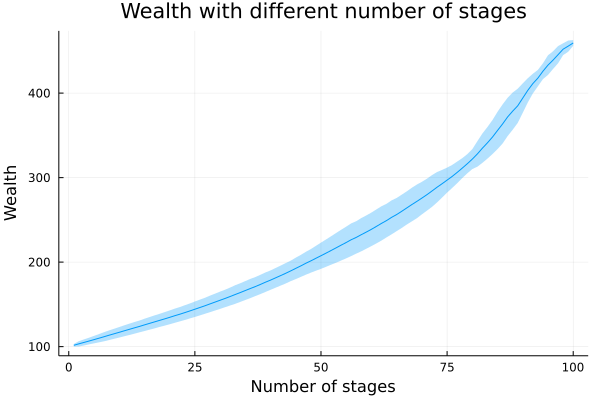

In [47]:
plot(mean_wealth, ribbon=std_wealth, fillalpha=.3,
    title = "Wealth with different number of stages", legend=false)
xlabel!("Number of stages")
ylabel!("Wealth")